# PyTorch CIFAR-10 categorisation project

1. Explore the data
1. Create a baseline to judge results against
1. Implement a neural network
1. Implement improvements
1. Evaluate different parameters

## 1. Explore the data

In [1]:
import torch
from torch import cuda
from torch import nn
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torchvision.datasets import CIFAR10
from torchvision import transforms
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from pathlib import Path

In [20]:
data_folder = r"../data"

transform = transforms.Compose([transforms.Resize(32),
                                transforms.ToTensor()])
CIFAR_data = CIFAR10(data_folder, train=True, transform=transform, download=True)

train_dataloader = DataLoader(CIFAR_data,
                          batch_size=4,
                          shuffle=True)

CIFAR_test_data = CIFAR10(data_folder, train=False, transform=transform)

test_dataloader = DataLoader(CIFAR_test_data,
                              batch_size=4,
                              shuffle=True)

Files already downloaded and verified


### Visualise data

The next cell creates train_X, train_y type data which we use to visualise the data and run our benchmark categorisation. The training of Neural Nets uses PyTorch dataloaders and not the objects created in cell below.

To help with initial data exploration, convert the entire data training set to 
tensors.

In [109]:
# to do that explicitly below. Images in DataLoader objects have pixel values
# in (0,1). The CIFAR_data.data has int values in (0,255) so have to convert
# to floats to take mean etc further down
train_imgs = torch.tensor(CIFAR_data.data).float()/255
train_y = torch.tensor(CIFAR_data.targets)
test_imgs = torch.tensor(CIFAR_test_data.data).float()/255
test_y = torch.tensor(CIFAR_test_data.targets)

classes = CIFAR_data.classes

# We need a map to get from index to class name.
# So need to reverse .class_to_idx dict:
labels_map = {}
for key, val in CIFAR_data.class_to_idx.items():
    labels_map[val] = key

Plot random sample of the data:

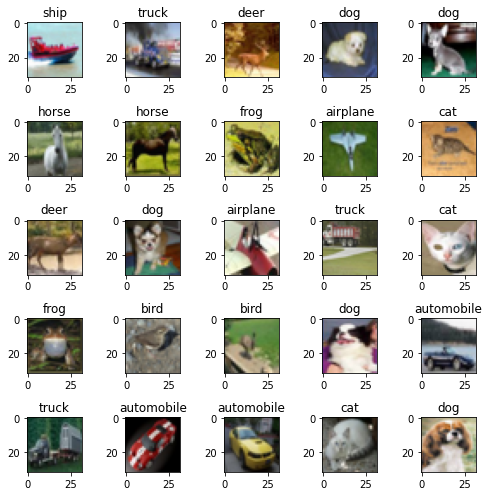

In [110]:
fig, axs = plt.subplots(5,5,figsize=(7,7))

for ax in axs.flatten():
    i = torch.randint(50000, (1,1)).item()
    ax.imshow(train_imgs[i])
    ax.set_title(labels_map[train_y[i].item()])
plt.tight_layout()

## Prepare data for benchmark categorisation

We create the training and validation data and labels.

The data is reshaped to a 4-dimensional tensor. dim 0 corresponds to list of images dim 1 is "depth" - so 3 layers for RGB; dim 2 and 3 are for the 32 pixels height and width of the images. 

We didvide pixel values by 255 so that PyTorch can work with floating point numbers in (0,1).

In [111]:
test_y.shape, test_imgs.shape, train_y.shape, train_imgs.shape

(torch.Size([10000]),
 torch.Size([10000, 32, 32, 3]),
 torch.Size([50000]),
 torch.Size([50000, 32, 32, 3]))

## Create a benchmark to judge neural net results against

Will an accuracy of above 10% imply that our neural net is doing better than chance and therefore doing a good job? Maybe.

To create a benchmark, we do a very simple prediction: we calculate the value of the "average" pixel for all the images in each category. Then for each image, we 

First create a benchmark to measure results of training neural net on.

We calculate the average RGB value for each pixel for each category. Then calculate the distance of an image form the average image for each category. Shortest distance is classified as that image. Can we do better than 10% accuracy??

In [112]:
avg_img = torch.zeros((10,32,32,3))
for i in np.arange(10):
    mask = train_y == i
    avg_img[i] = train_imgs[mask].mean(0)
    

Display our "average images". Kinda cool! The automobile and truck look like vehicles coming through the mist and the colours look different for different categories. There will be a lot of confusion between wild animals and cars/trucks for example, but the prediction based on distance from mean image should be quite good.

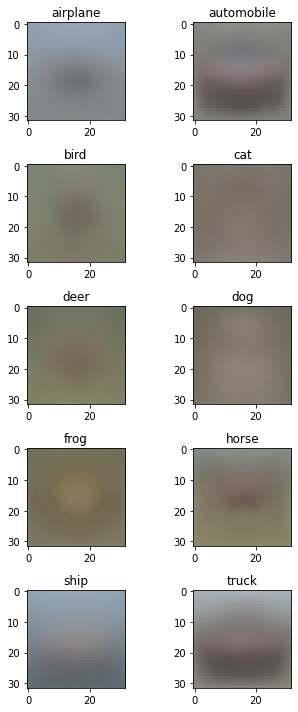

In [113]:
fig, axs = plt.subplots(5,2,figsize=(5,10))

for i, ax in enumerate(axs.flatten()):
    ax.imshow(avg_img[i])
    ax.set_title(labels_map[i])
plt.tight_layout()

Test our benchmark prediction. 28%!! Pretty good for just calculating an average. We now need our neural net to outperform 28% accuracy to be any good.

In [114]:
def cifar_distance(a,b): return ((a-b)**2).abs().mean((-1,-2,-3))
def predictions(a): return torch.argmin(a, dim=1)

preds = predictions(cifar_distance(test_imgs[:,None], avg_img[None]))
accuracy = (preds == test_y).sum()/test_imgs.shape[0]
accuracy

tensor(0.2774)

Just for curiousity, let's plot the confusion matrix. Some parts are as we expect from out crude method: it gets confused between deer and frogs (green backgrounds?) and birds and planes (sky?). 

Finally, there were 1000 of each category in the 10,000 test data set. However, our simple rule predicted either airplane or frog 4,500 times. So a lot of images look like the average frog or airplane!

(tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 tensor([2016,  657,  378,  211,  432, 1065, 2485,  622,  885, 1249]))

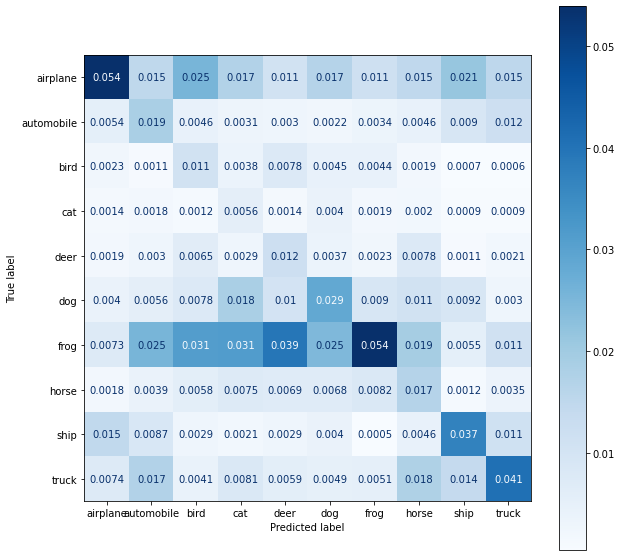

In [115]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
display(torch.unique(preds, return_counts=True))

cm = confusion_matrix(preds, test_y,
                      normalize='all')
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=classes
                             )

fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax, cmap='Blues')
ax.grid(False)

## 3. Implement a neural network

Create the initial neural network

In [116]:
device = torch.device('cuda:0' if cuda.is_available() else 'cpu')
device

device(type='cpu')

Prepare the data. To check code runs, I will do a tiny amount of training data.

We also flatten the image data to vectors so that we can feed into a basic NN.

In [117]:
num_epochs = 50
batch_size = 100
learning_rate = 0.005

# I wasn't going to copy Cactus_classification, but defining 'criterion'
# gives good flexibility
criterion = nn.CrossEntropyLoss()

#### Prepare data

The code below is almost an exact copy of cell 2, above. We've recreated to give us the flexibility to have a smaller training and test set whilst running on local machines. We also have target tranform below which one-hot-encodes the labels.

In [118]:
transform = transforms.Compose([transforms.ToTensor(), #transforms.Resize(32),
                                # transforms.Lambda(lambda x: torch.flatten(x))
                               ])
target_transforms = transforms.Lambda(lambda y: torch.zeros(10, dtype=torch.float)
                                     .scatter_(0, torch.tensor(y), value=1))

# Prepare 1000 sample training set
CIFAR_data_small = CIFAR10(data_folder, train=True, 
                           transform=transform,
                           target_transform=target_transforms,
                           download=False)
CIFAR_data_small.data = CIFAR_data_small.data[:]
CIFAR_data_small.targets = CIFAR_data_small.targets[:]

# Prepare 1000 sample test set (weird balance, but easy to test)
CIFAR_test_small = CIFAR10(data_folder, train=False, 
                           transform=transform,
                           target_transform=target_transforms,
                           download=False)
CIFAR_test_small.data = CIFAR_test_small.data[:]
CIFAR_test_small.targets = CIFAR_test_small.targets[:]

train_small_dl = DataLoader(CIFAR_test_small,
                          batch_size=batch_size,
                          shuffle=True)

test_small_dl = DataLoader(CIFAR_test_small,
                          batch_size=batch_size,
                          shuffle=True)

In [119]:
CIFAR_data_small.data.shape, type(CIFAR_data_small.data), CIFAR_test_small.data.shape

((50000, 32, 32, 3), numpy.ndarray, (10000, 32, 32, 3))

Check that we have one-hot encoded the labels data. Looks like we have!

In [120]:
train_features, train_labels = next(iter(test_small_dl))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
# img = train_features[0].permute(1,2,0)
label = train_labels[0]
# plt.imshow(img)
# plt.show()
print(f"Label: {label}")

Feature batch shape: torch.Size([100, 3, 32, 32])
Labels batch shape: torch.Size([100, 10])
Label: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.])


In [121]:
# Define model

# models should subclass nn.Module. Docs here:
# https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        # This flattens the 3 x 32 x 32 image matrices to vectors
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            # nn.Flatten(),
            nn.Linear(3*32*32, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=3072, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [122]:
# print("Model structure: ", model, "\n\n")

# for name, param in model.named_parameters():
#     print(f"Layer: {name} | Size: {param.size()} | Values : {param[:2]} \n")

## Training the model

In [123]:
def train(model, train_small_dl=train_small_dl, test_small_dl=test_small_dl, num_epochs=num_epochs, learning_rate=learning_rate):
    
    criterion = nn.CrossEntropyLoss()
    # keeping-track-of-losses 
    train_losses = []
    valid_losses = []
    # set optimiser here - it uses model parameters as input
    optimizer = torch.optim.SGD(model.parameters(),lr = learning_rate)

    for epoch in range(1, num_epochs + 1):
    # keep-track-of-training-and-validation-loss
        train_loss = 0.0
        valid_loss = 0.0
    
    # training-the-model
        model.train()
        for data, target in train_small_dl:
        # move-tensors-to-GPU / CPU
            data = data.to(device)
            target = target.to(device)
            target_i =torch.argmax(target, dim=1)
        # clear-the-gradients-of-all-optimized-variables
            optimizer.zero_grad()
        # forward-pass: compute-predicted-outputs-by-passing-inputs-to-the-model
            output = model(data)
        # calculate-the-batch-loss
            loss = criterion(output, target_i)
        # backward-pass: compute-gradient-of-the-loss-wrt-model-parameters
            loss.backward()
        # perform-a-single-optimization-step (parameter-update)
            optimizer.step()
        # update-training-loss
            train_loss += loss.item() * data.size(0)
        
    # validate-the-model
        model.eval()
        for data, target in test_small_dl:
        
            data = data.to(device)
            target = target.to(device)
            target_i =torch.argmax(target, dim=1)
            output = model(data)
        
            loss = criterion(output, target_i)
        
        # update-average-validation-loss 
            valid_loss += loss.item() * data.size(0)
    
    # calculate-average-losses
        train_loss = train_loss/len(train_small_dl.sampler)
        valid_loss = valid_loss/len(test_small_dl.sampler)
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)
        
    # print-training/validation-statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, train_loss, valid_loss))
    
    

In [124]:
%%time
train(model)

Epoch: 1 	Training Loss: 2.290035 	Validation Loss: 2.279410
Epoch: 2 	Training Loss: 2.270645 	Validation Loss: 2.259652
Epoch: 3 	Training Loss: 2.248220 	Validation Loss: 2.234580
Epoch: 4 	Training Loss: 2.220629 	Validation Loss: 2.203865
Epoch: 5 	Training Loss: 2.187746 	Validation Loss: 2.168728
Epoch: 6 	Training Loss: 2.151861 	Validation Loss: 2.132338
Epoch: 7 	Training Loss: 2.116874 	Validation Loss: 2.099257
Epoch: 8 	Training Loss: 2.085649 	Validation Loss: 2.069957
Epoch: 9 	Training Loss: 2.059042 	Validation Loss: 2.045786
Epoch: 10 	Training Loss: 2.035595 	Validation Loss: 2.022868
Epoch: 11 	Training Loss: 2.015117 	Validation Loss: 2.003413
Epoch: 12 	Training Loss: 1.995314 	Validation Loss: 1.986324
Epoch: 13 	Training Loss: 1.978986 	Validation Loss: 1.968737
Epoch: 14 	Training Loss: 1.963983 	Validation Loss: 1.955485
Epoch: 15 	Training Loss: 1.949191 	Validation Loss: 1.942426
Epoch: 16 	Training Loss: 1.936876 	Validation Loss: 1.928967
Epoch: 17 	Traini

## Test model on validation data

In [125]:
def test(model, test_small_dl=test_small_dl):
    # test-the-model
    model.eval()  # it-disables-dropout
    with torch.no_grad():
        correct = 0
        total = 0
    # below calculates accuracy. Alex adapted from lab code and
    # it's not very pretty code. I transformed labels from one-
    # hot-encoded to integer labels and did the same for the 
    # softmax output in `predicted`
        for images, labels in test_small_dl:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            predicted = torch.argmax(outputs.data, dim=1)
            total += labels.size(0)
            labels = torch.argmax(labels, dim=1)
            correct += (predicted == labels).sum().item()
          
        print('Test Accuracy of the model: {} %'.format(100 * correct / total))

In [126]:
test(model)
# Save 
torch.save(model.state_dict(), 'model.ckpt')

Test Accuracy of the model: 40.31 %


# Improvement

The accuracy doesn't look good enough. So let's explore any room for improvement, potentially:
- CNN
- Standard Normalization
- Regularization by dropout/L2
- More data
- tuning parameters: batch size, learning rate, no of epochs, optimizer

## CNN

CNN (convolutional neural network, also called ConvNet) is a popular technique for image classification in machine learning. Unlike traditional fully connected neural network, CNN somehow retains the spatial relationship among features (i.e. pixels) of images. In the below, we will keep the previous neural network structure in the end, but add CNN layers in the beginning. As the image is small, we will start with 3x3 kernel size, 2x2 max pooling, with suitable padding generating same output shape. 

In [142]:
# Reference: https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
            #https://cs231n.github.io/convolutional-networks/

#define model architecture
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 12, 3, padding='same') #2D convolution layer, kernel 3x3, 
        self.pool = nn.MaxPool2d(2, 2)   #2D max pooling
        self.fc1 = nn.Linear(3072, 512)
        self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = CNN()


#train the model
train(net, learning_rate=0.1)

#save
torch.save(net.state_dict(), './cifar_net.pth')

Epoch: 1 	Training Loss: 2.228427 	Validation Loss: 2.133549
Epoch: 2 	Training Loss: 2.055255 	Validation Loss: 1.964064
Epoch: 3 	Training Loss: 1.914410 	Validation Loss: 1.853548
Epoch: 4 	Training Loss: 1.824661 	Validation Loss: 1.717767
Epoch: 5 	Training Loss: 1.725272 	Validation Loss: 1.687707
Epoch: 6 	Training Loss: 1.659382 	Validation Loss: 1.569039
Epoch: 7 	Training Loss: 1.575355 	Validation Loss: 1.452784
Epoch: 8 	Training Loss: 1.544095 	Validation Loss: 1.623855
Epoch: 9 	Training Loss: 1.462699 	Validation Loss: 1.361005
Epoch: 10 	Training Loss: 1.418799 	Validation Loss: 1.289482
Epoch: 11 	Training Loss: 1.360260 	Validation Loss: 1.277462
Epoch: 12 	Training Loss: 1.299870 	Validation Loss: 1.153254
Epoch: 13 	Training Loss: 1.235076 	Validation Loss: 1.195351
Epoch: 14 	Training Loss: 1.185428 	Validation Loss: 1.466237
Epoch: 15 	Training Loss: 1.128493 	Validation Loss: 1.299831
Epoch: 16 	Training Loss: 1.069923 	Validation Loss: 0.944624
Epoch: 17 	Traini

In [143]:
test(net)

Test Accuracy of the model: 99.96 %


In [144]:
# Reference: https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
            #https://cs231n.github.io/convolutional-networks/

#define model architecture
class CNN2(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 12, 3, padding='same') #2D convolution layer, kernel 3x3, 
        self.pool = nn.MaxPool2d(2, 2)   #2D max pooling
        self.conv2 = nn.Conv2d(12, 48, 3, padding='same') #another #2D convolution layer, kernel 3x3, 
        self.fc1 = nn.Linear(3072, 512)
        self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net2 = CNN2()


#train the model
train(net2, learning_rate=0.1)

#save
torch.save(net2.state_dict(), './cifar_net.pth')

Epoch: 1 	Training Loss: 2.298319 	Validation Loss: 2.285537
Epoch: 2 	Training Loss: 2.221617 	Validation Loss: 2.172532
Epoch: 3 	Training Loss: 2.064569 	Validation Loss: 1.943914
Epoch: 4 	Training Loss: 1.943301 	Validation Loss: 1.835836
Epoch: 5 	Training Loss: 1.843276 	Validation Loss: 1.794809
Epoch: 6 	Training Loss: 1.735568 	Validation Loss: 1.831933
Epoch: 7 	Training Loss: 1.667666 	Validation Loss: 1.514334
Epoch: 8 	Training Loss: 1.580061 	Validation Loss: 1.853626
Epoch: 9 	Training Loss: 1.500492 	Validation Loss: 1.380346
Epoch: 10 	Training Loss: 1.432135 	Validation Loss: 1.316829
Epoch: 11 	Training Loss: 1.371111 	Validation Loss: 1.292717
Epoch: 12 	Training Loss: 1.307454 	Validation Loss: 1.242502
Epoch: 13 	Training Loss: 1.225664 	Validation Loss: 1.177012
Epoch: 14 	Training Loss: 1.172161 	Validation Loss: 1.022802
Epoch: 15 	Training Loss: 1.111772 	Validation Loss: 0.952966
Epoch: 16 	Training Loss: 1.024009 	Validation Loss: 0.965038
Epoch: 17 	Traini

In [145]:
test(net2)

Test Accuracy of the model: 100.0 %


After adding one convolution layer further, its accuracy is 99.99% or 100.0% (running twice to double chek results). There should be little room for further improvement and no need for further tuning and testing parameters, except for experiment purpose.